# Num iterations to convergence
Created 18/09/2025

Objectives:
* Just run the algorithms a number of times to characterise how many iterations it takes until convergence.

# Package imports

In [1]:
import sys

In [2]:
sys.path.append("../../../")

In [3]:
from itertools import chain
import re

In [4]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os
import pickle

In [5]:
import numpy as np
import jax.numpy as jnp

import matplotlib.pyplot as plt
import matplotlib

In [6]:
import quimb as qu
import quimb.tensor as qtn
from quimb.tensor.optimize import TNOptimizer

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:36: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


# Load data

In [7]:
DATA_DIR = r"../../../data/transverse_cluster_200_site_dmrg"

In [8]:
loaded_data = list()

for local_file_name in os.listdir(DATA_DIR):
    f_name = r"{}/{}".format(DATA_DIR, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        loaded_data.append(data)

In [9]:
b_parameters = sorted(list(d['paramters']['B'] for d in loaded_data))

In [10]:
psi_dict = dict()

In [11]:
for b in b_parameters:
    psi = next(
        d['wavefunction']
        for d in loaded_data
        if d['paramters']['B'] == b
    )

    rounded_b = round(b, 1)
    psi_dict[rounded_b] = psi

# Definitions

In [12]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])

In [13]:
symmetry_actions = [
    [np_I, np_I],
    [np_I, np_X],
    [np_X, np_I],
    [np_X, np_X]
]

In [14]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

In [15]:
def generate_problem_rdm(quimb_psi, symmetry_site_pairs, leftmost_symmetry_site,
                         num_symmetry_sites, num_boundary_sites):
    q_top = quimb_psi.copy(deep=True)
    for i, s in symmetry_site_pairs:
        q_top.gate(
            s,
            where=i,
            contract=False,
            inplace=True
        )

    
    indices_to_map = list(chain(
        range(leftmost_symmetry_site-num_boundary_sites, leftmost_symmetry_site),
        range(leftmost_symmetry_site+num_symmetry_sites, leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites)
    ))

    index_mapping = {f'k{i}': f'b{i}' for i in indices_to_map}

    q_bottom = (
        quimb_psi
        .copy()
        .reindex(index_mapping, inplace=True)
        .conj()
    )

    sites_to_contract = {
        'left': list(range(leftmost_symmetry_site-num_boundary_sites)),
        'middle': list(range(leftmost_symmetry_site, leftmost_symmetry_site+num_symmetry_sites)),
        'right': list(range(leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites, quimb_psi.L))
    }

    tags_to_contract = {
        k: [f'I{i}' for i in v]
        for k, v in sites_to_contract.items()
    }

    tn = (q_top & q_bottom)

    tnc = (
        tn
        .contract(tags_to_contract['left'])
        .contract(tags_to_contract['middle'])
        .contract(tags_to_contract['right'])
    )

    return tnc

## Optimisation functions

In [16]:
def loss(circ_pair, problem_rdm):
    c = (problem_rdm & circ_pair)^...

    c_abs_squared = (
        c
        *jnp.conjugate(c)
    )
    c_abs_squared = jnp.real(c_abs_squared)

    out = 1-c_abs_squared

    return out

## Gate & circuit functions

In [17]:
def single_qubit_layer(circ, gate_round=None):
    """Apply a parametrizable layer of single qubit ``U3`` gates.
    """
    for i in range(circ.N):
        # initialize with random parameters
        params = qu.randn(3, dist='uniform')
        circ.apply_gate(
            'U3',
            *params,
            i,
            gate_round=gate_round,
            parametrize=True
        )

In [18]:
def two_qubit_layer(circ, gate2='CZ', start=0, gate_round=None):
    """Apply a layer of constant entangling gates.
    """
    num_sites = circ.N # Assuming this is even
    sites = [
        i % num_sites
        for i in range(start, start + num_sites)
    ]
    
    site_pairs = list(zip(sites[::2], sites[1::2]))

    for i, j in site_pairs:
        circ.apply_gate(
            gate2,
            i,
            j,
            gate_round=gate_round
        )

In [19]:
def ansatz_circuit(n, depth, first_site=0, gate2='CZ',
                   gate_tag=None, **kwargs):
    """Construct a circuit of single qubit and entangling layers.
    """
    circ = qtn.Circuit(n, **kwargs)

    for r in range(depth):
        # single qubit gate layer
        single_qubit_layer(circ, gate_round=r)

        # alternate between forward and backward CZ layers
        two_qubit_layer(
            circ, gate2=gate2, gate_round=r, start=r % 2)

    # add a final single qubit layer
    single_qubit_layer(circ, gate_round=r + 1)

    circ = circ.get_uni(transposed=True)

    if gate_tag is not None:
        for t in circ.tensors:
            t.add_tag(gate_tag)

    if first_site != 0:
        index_labels = ['k', 'b']

        index_map = {
            f'{l}{i}': f'{l}{i+first_site}'
            for i in range(n)
            for l in index_labels
        }

        circ.reindex(index_map, inplace=True)

    return circ

In [20]:
def ansatz_circuit_pair(leftmost_symmetry_site,
    num_symmetry_sites, num_boundary_sites, depth,
    gate2='CZ', **kwargs):
    """Construct a circuit of single qubit and entangling layers.
    """
    left_start_site = leftmost_symmetry_site-num_boundary_sites
    right_start_site = leftmost_symmetry_site+num_symmetry_sites

    left_circuit = ansatz_circuit(
        num_boundary_sites,
        depth,
        first_site=left_start_site,
        gate2=gate2,
        gate_tag='left',
        **kwargs
    )

    right_circuit = ansatz_circuit(
        num_boundary_sites,
        depth,
        first_site=right_start_site,
        gate2=gate2,
        gate_tag='right',
        **kwargs
    )

    circ_pair = left_circuit & right_circuit

    return circ_pair

In [21]:
def split_circ_pair(circ_pair):
    left_circuit = qtn.TensorNetwork(
        list(map(circ_pair.tensor_map.__getitem__, circ_pair.tag_map['left']))
    )

    right_circuit = qtn.TensorNetwork(
        list(map(circ_pair.tensor_map.__getitem__, circ_pair.tag_map['right']))
    )

    return (left_circuit, right_circuit)

# Sweep

In [22]:
num_boundary_sites=2
left_most_symmetry_site=60
num_symmetry_sites=80

total_physical_dim = 2**num_boundary_sites

In [23]:
n=2
depth=2
gate2='CZ'

In [24]:
num_iterations=350

In [25]:
num_random_seeds=20

In [26]:
nhop=3

In [27]:
from collections import defaultdict

In [28]:
all_losses = defaultdict(list)

In [29]:
for k1, mps_psi in psi_dict.items():
    print(k1)

    psi_arrays = list()
    psi_arrays.append(mps_psi.get_B(0, 'Th')[0, ...].to_ndarray())
    for i in range(1, mps_psi.L-1):
        psi_arrays.append(mps_psi.get_B(i).to_ndarray())
    psi_arrays.append(mps_psi.get_B(mps_psi.L-1)[..., 0].to_ndarray())

    q1 = (
        qtn
        .tensor_1d
        .MatrixProductState(psi_arrays, shape='lpr')
    )

    for k2, bs in enumerate(symmetry_actions[1:], start=1):
        print(f'-> {k2}')
        for _ in range(num_random_seeds):
            symmetry_site_pairs = (
                [(i, bs[0]) for i in range(left_most_symmetry_site, left_most_symmetry_site+num_symmetry_sites, 2)]
                + [(i, bs[1]) for i in range(left_most_symmetry_site+1, left_most_symmetry_site+num_symmetry_sites+1, 2)]
            )
    
            problem_rdm = generate_problem_rdm(
                q1,
                symmetry_site_pairs,
                left_most_symmetry_site,
                num_symmetry_sites,
                num_boundary_sites
            )
    
            circ_pair = ansatz_circuit_pair(
                left_most_symmetry_site,
                num_symmetry_sites,
                num_boundary_sites,
                depth
            )
        
            optmzr = qtn.optimize.TNOptimizer(
                circ_pair,                                
                loss_fn=loss,
                loss_constants={'problem_rdm': problem_rdm},
                #autodiff_backend='jax',
                tags=['U3'],
                optimizer='COBYLA',
                progbar=False
            )
    
            optmzr.optimize(
                num_iterations,
                jac=False,
                hessp=False
            )
    
            all_losses[(k1, k2)].append(optmzr.losses)

0.0
-> 1
-> 2
-> 3
0.1
-> 1
-> 2
-> 3
0.2
-> 1
-> 2
-> 3
0.3
-> 1
-> 2
-> 3
0.4
-> 1
-> 2
-> 3
0.5
-> 1
-> 2
-> 3
0.6
-> 1
-> 2
-> 3
0.7
-> 1
-> 2
-> 3
0.8
-> 1
-> 2
-> 3
0.9
-> 1
-> 2
-> 3
1.0
-> 1
-> 2
-> 3
1.1
-> 1
-> 2
-> 3
1.2
-> 1
-> 2
-> 3
1.3
-> 1
-> 2
-> 3
1.4
-> 1
-> 2
-> 3
1.5
-> 1
-> 2
-> 3
1.6
-> 1
-> 2
-> 3
1.7
-> 1
-> 2
-> 3
1.8
-> 1
-> 2
-> 3
1.9
-> 1
-> 2
-> 3
2.0
-> 1
-> 2
-> 3


# Analyse

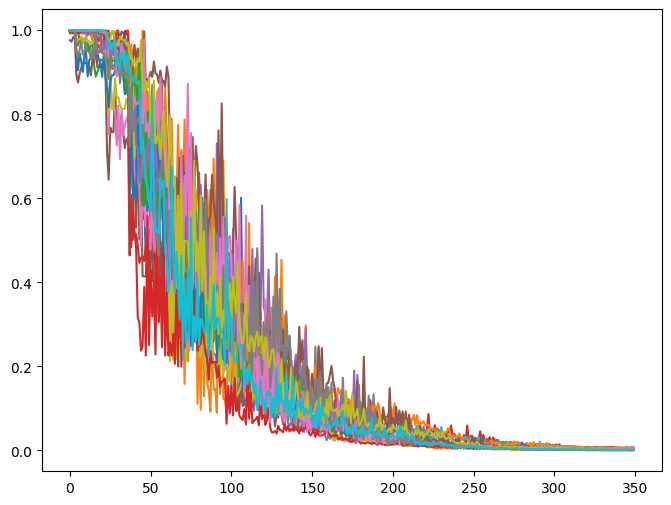

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))

for X in all_losses[(0, 1)]:
    ax.plot(X)

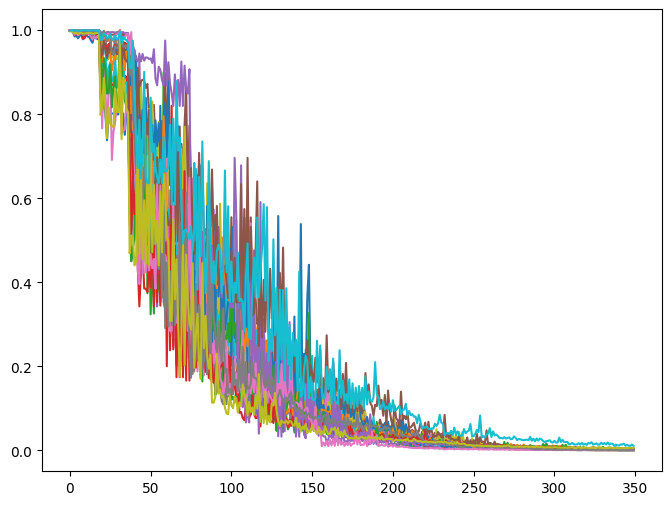

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))

for X in all_losses[(0, 2)]:
    ax.plot(X)

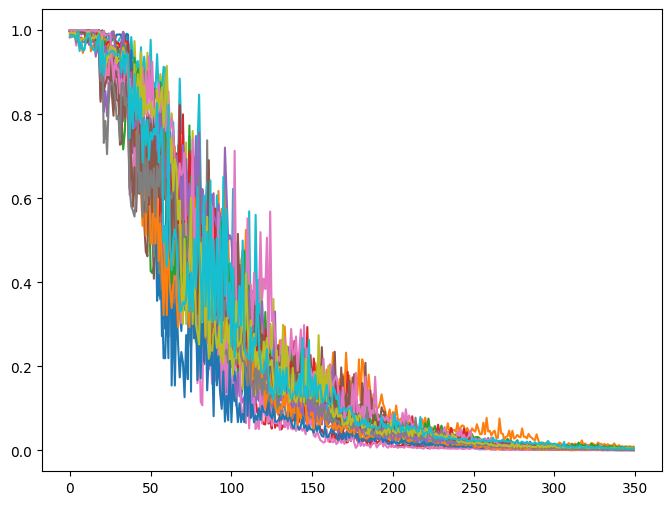

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))

for X in all_losses[(0, 3)]:
    ax.plot(X)

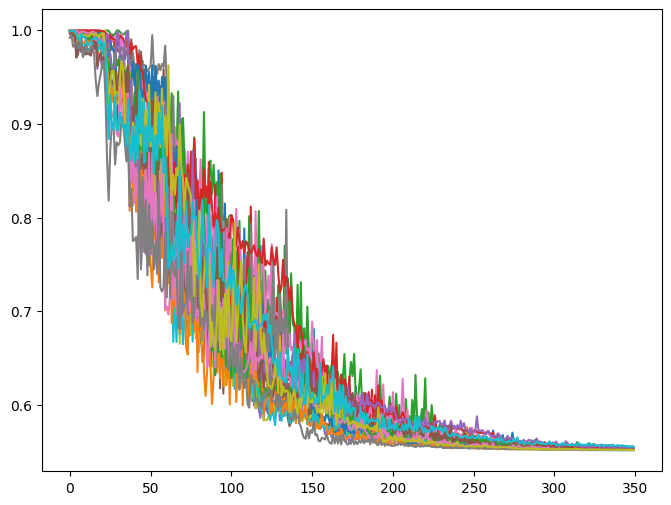

In [33]:
fig, ax = plt.subplots(figsize=(8, 6))

for X in all_losses[(0.9, 1)]:
    ax.plot(X)

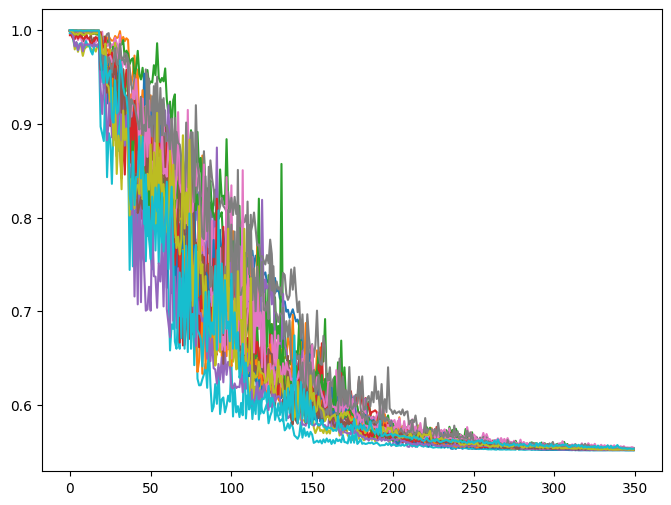

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))

for X in all_losses[(0.9, 2)]:
    ax.plot(X)

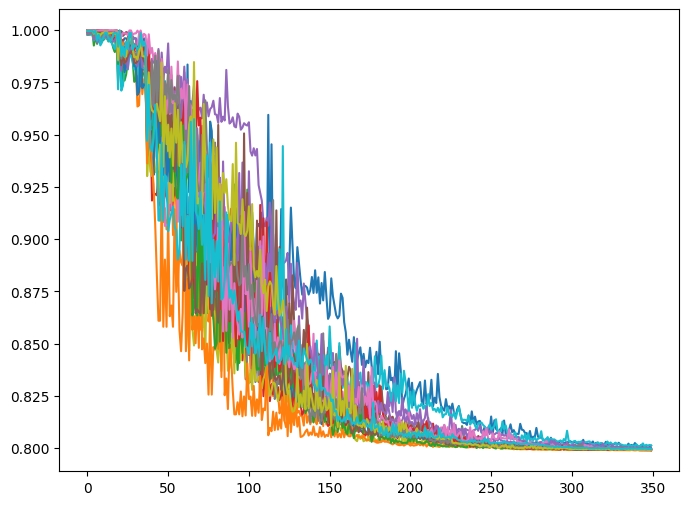

In [35]:
fig, ax = plt.subplots(figsize=(8, 6))

for X in all_losses[(0.9, 3)]:
    ax.plot(X)

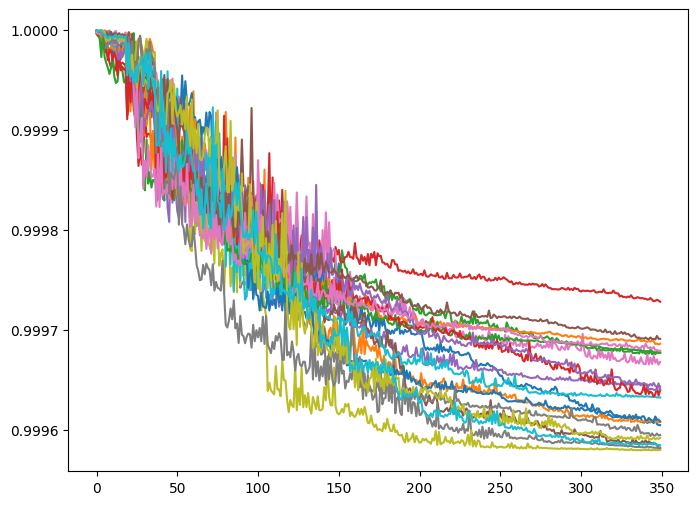

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))

for X in all_losses[(1, 3)]:
    ax.plot(X)

In [106]:
def truncate_losses(X, loss_tol=0.85, delta_tol = 0.007, delta_window=10):
    loss_tol_cond = X < loss_tol

    dX_cond = np.abs((X[1:] - X[:-1])) < delta_tol
    delta_tol_conds = [
        dX_cond[i:-delta_window+1+i] for i in range(delta_window-1)
    ]
    delta_tol_conds.append(dX_cond[delta_window-1:])
    delta_tol_conds = np.array(delta_tol_conds)

    delta_tol_cond = np.all(delta_tol_conds, axis=0)

    all_conds = loss_tol_cond[delta_window:] & delta_tol_cond

    first_arg = np.argmax(all_conds) + delta_window

    return X[:first_arg + 1]

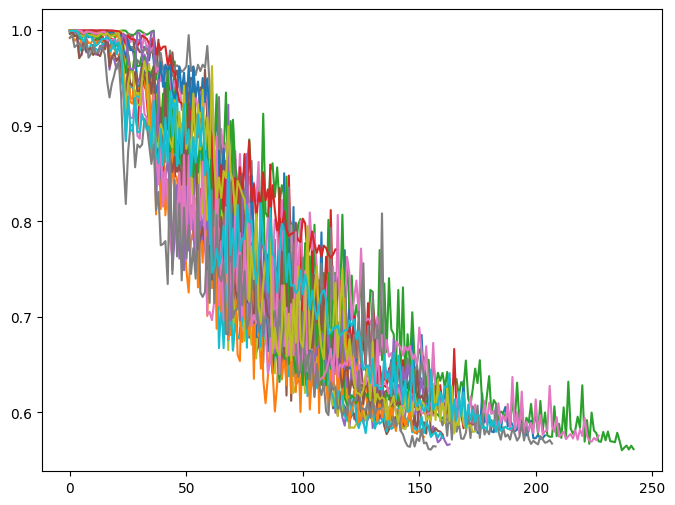

In [40]:
fig, ax = plt.subplots(figsize=(8, 6))

for X in all_losses[(0.9, 1)]:
    ax.plot(truncate_losses(np.array(X)))

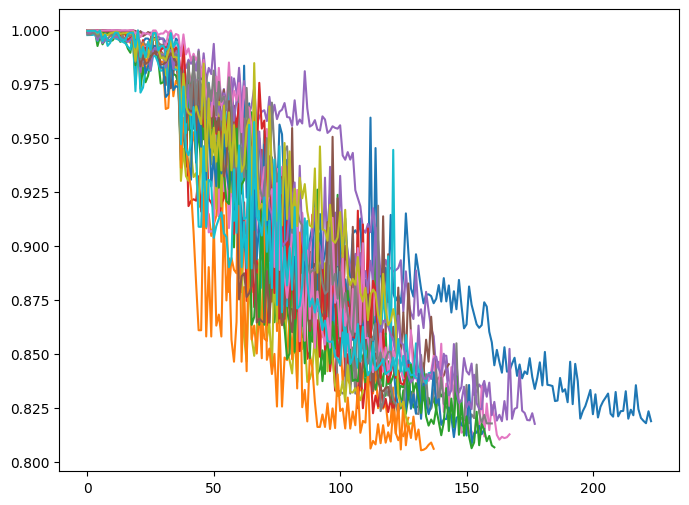

In [41]:
fig, ax = plt.subplots(figsize=(8, 6))

for X in all_losses[(0.9, 3)]:
    ax.plot(truncate_losses(np.array(X)))

In [107]:
trunc_all_losses = {
    k: [truncate_losses(np.array(l)) for l in v]
    for k, v in all_losses.items()
}

In [43]:
trunc_mean_final_losses = {
    k: np.mean(np.array([X[-1] for X in v]))
    for k, v in trunc_all_losses.items()
}

In [44]:
trunc_mean_final_losses_array = np.zeros((21, 3))

for (x, y), v in trunc_mean_final_losses.items():
    trunc_mean_final_losses_array[int(10*x), y-1] = v

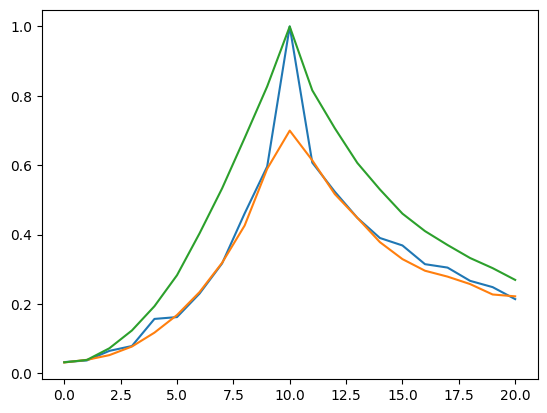

In [45]:
for i in range(3):
    plt.plot(trunc_mean_final_losses_array[:, i])

Interesting, but ignore for simplicity.

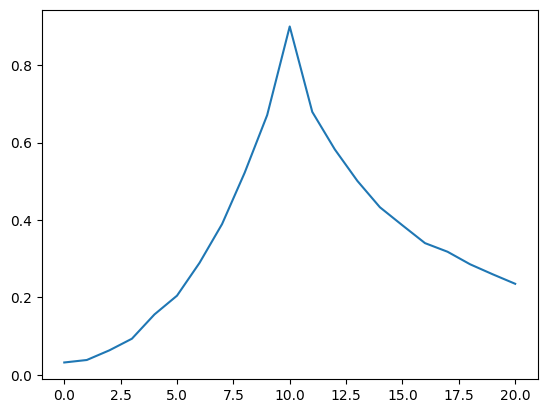

In [46]:
plt.plot(np.mean(trunc_mean_final_losses_array, axis=1))

In [47]:
trunc_var_final_losses = list()

for k1 in psi_dict:
    final_losses = list()
    for k2 in range(1, 4):
        final_losses.extend(
            [l[-1] for l in trunc_all_losses[(k1, k2)]]
        )

    trunc_var_final_losses.append(np.var(np.array(final_losses)))

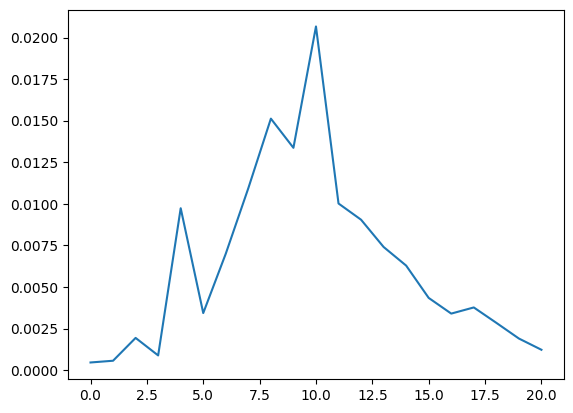

In [48]:
plt.plot(trunc_var_final_losses)

In [49]:
final_losses_array = np.zeros((21, 30))

for k1, b in enumerate(psi_dict):
    for k2 in range(3):
        for k3, X in enumerate(trunc_all_losses[(b, k2+1)][:10]):
            final_losses_array[k1, 10*k2+k3] = X[-1]

In [50]:
mean_final_losses = np.mean(final_losses_array, axis=1)
std_final_losses = np.std(final_losses_array, axis=1)
min_final_losses = np.min(final_losses_array, axis=1)
max_final_losses = np.max(final_losses_array, axis=1)
first_quartile_final_losses = np.quantile(final_losses_array, 0.25, axis=1)
third_quartile_final_losses = np.quantile(final_losses_array, 0.75, axis=1)

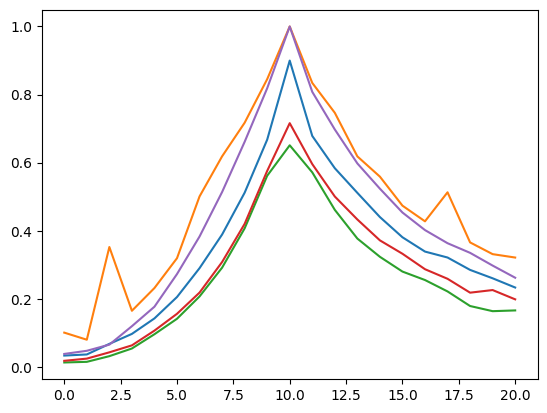

In [51]:
plt.plot(mean_final_losses)
plt.plot(max_final_losses)
plt.plot(min_final_losses)
plt.plot(first_quartile_final_losses)
plt.plot(third_quartile_final_losses)

In [52]:
num_iters_array = np.zeros((21, 30))

for k1, b in enumerate(psi_dict):
    for k2 in range(3):
        for k3, X in enumerate(trunc_all_losses[(b, k2+1)][:10]):
            num_iters_array[k1, 10*k2+k3] = len(X)

In [53]:
mean_num_iters = list()
std_num_iters = list()
min_num_iters = list()
max_num_iters = list()
first_quartile_num_iters = list()
third_quartile_num_iters = list()

for k1 in psi_dict:
    num_iters = list()
    for k2 in range(1, 4):
        num_iters.extend(
            [len(l) for l in trunc_all_losses[(k1, k2)]]
        )

    mean_num_iters.append(np.mean(np.array(num_iters)))
    std_num_iters.append(np.std(np.array(num_iters)))
    min_num_iters.append(np.min(np.array(num_iters)))
    max_num_iters.append(np.max(np.array(num_iters)))
    first_quartile_num_iters.append(np.quantile(np.array(num_iters), 0.25))
    third_quartile_num_iters.append(np.quantile(np.array(num_iters), 0.75))

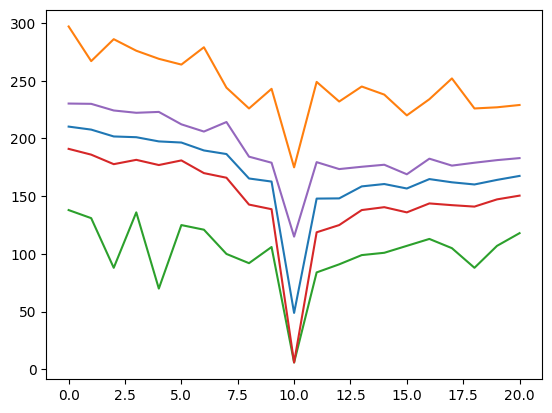

In [54]:
plt.plot(mean_num_iters)
plt.plot(max_num_iters)
plt.plot(min_num_iters)
plt.plot(first_quartile_num_iters)
plt.plot(third_quartile_num_iters)

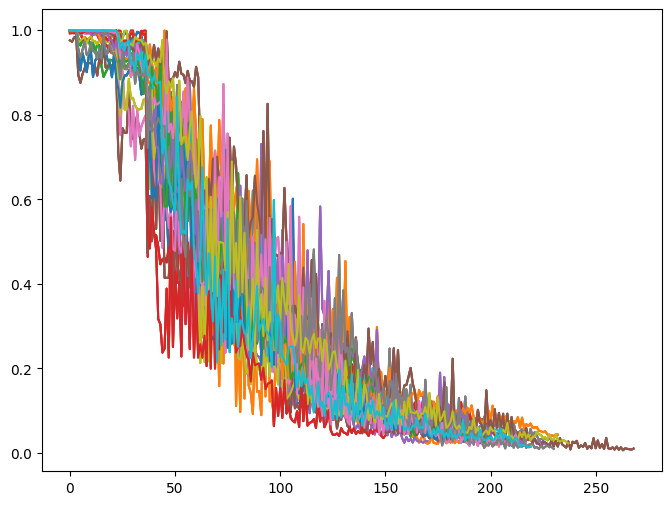

In [55]:
fig, ax = plt.subplots(figsize=(8, 6))

for i in range(1, 4):
    for X in trunc_all_losses[(0, 1)]:
        ax.plot(X)

In [56]:
hist_values = np.concatenate([
    X for i in range(1,4) for X in trunc_all_losses[(0, i)]
])

(array([ 34.,  29.,  25.,  29.,  22.,  40.,  32.,  34.,  42.,  36.,  55.,
         62.,  50.,  45.,  47.,  61.,  84., 143., 176., 638.]),
 array([0.95019543, 0.95268566, 0.95517589, 0.95766612, 0.96015635,
        0.96264657, 0.9651368 , 0.96762703, 0.97011726, 0.97260749,
        0.97509772, 0.97758794, 0.98007817, 0.9825684 , 0.98505863,
        0.98754886, 0.99003909, 0.99252931, 0.99501954, 0.99750977,
        1.        ]),
 <BarContainer object of 20 artists>)

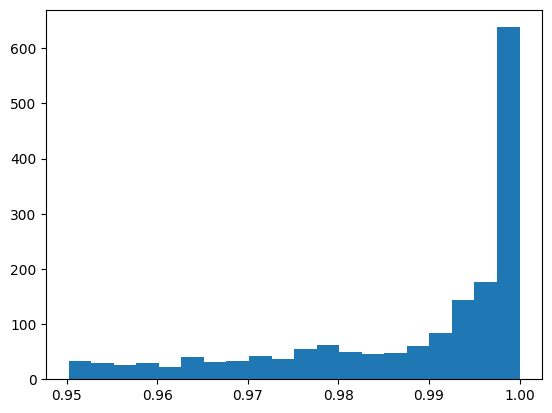

In [57]:
plt.hist(hist_values[hist_values>0.95], bins=20)

Can use plots like this to identify the "barren plateau".

In [58]:
mean_lbp = list()
std_lbp = list()
min_lbp = list()
max_lbp = list()
first_quartile_lbp = list()
third_quartile_lbp = list()

for k1 in psi_dict:
    leaves_barren_plateaus = list()
    for k2 in range(1, 4):
        for l in trunc_all_losses[(k1, k2)]:
            X = np.array(l)
            leaves_barren_plateau = np.argmax(X < 0.95)
            leaves_barren_plateaus.append(leaves_barren_plateau)

    mean_lbp.append(np.mean(np.array(leaves_barren_plateaus)))
    std_lbp.append(np.std(np.array(leaves_barren_plateaus)))
    min_lbp.append(np.min(np.array(leaves_barren_plateaus)))
    max_lbp.append(np.max(np.array(leaves_barren_plateaus)))
    first_quartile_lbp.append(np.quantile(np.array(leaves_barren_plateaus), 0.25))
    third_quartile_lbp.append(np.quantile(np.array(leaves_barren_plateaus), 0.75))

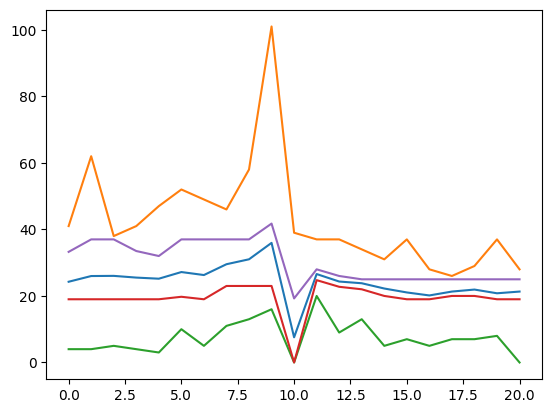

In [59]:
plt.plot(mean_lbp)
plt.plot(max_lbp)
plt.plot(min_lbp)
plt.plot(first_quartile_lbp)
plt.plot(third_quartile_lbp)

Kind of the opposite of what I was expecting to see!
Spends longer in barren plateau for more strongly correlated states.
Therefore the speedup occurs in the learning. Hard to quantify why this is though, because the optimal is higher and so the optimisation has a shorter distance to go. Perhaps this is the reason why?

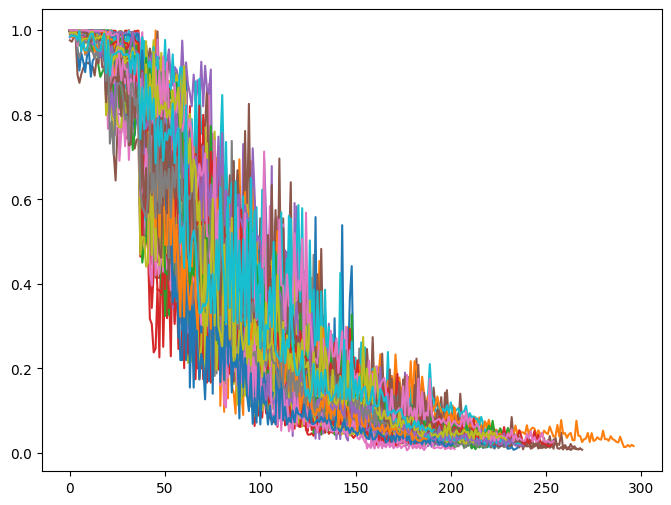

In [60]:
fig, ax = plt.subplots(figsize=(8, 6))

for i in range(1, 4):
    for X in trunc_all_losses[(0, i)]:
        ax.plot(X)

In [108]:
grouped_final_losses_array = np.zeros((21, 3,  num_random_seeds))

for k1, b in enumerate(psi_dict):
    for k2 in range(3):
        for k3, X in enumerate(trunc_all_losses[(b, k2+1)]):
            grouped_final_losses_array[k1, k2, k3] = X[-1]

## Group by applied symmetry

In [109]:
mean_grouped_final_losses = np.mean(grouped_final_losses_array, axis=-1)
std_grouped_final_losses = np.std(grouped_final_losses_array, axis=-1)
min_grouped_final_losses = np.min(grouped_final_losses_array, axis=-1)
max_grouped_final_losses = np.max(grouped_final_losses_array, axis=-1)
first_quartile_grouped_final_losses = np.quantile(grouped_final_losses_array, 0.25, axis=-1)
third_quartile_grouped_final_losses = np.quantile(grouped_final_losses_array, 0.75, axis=-1)

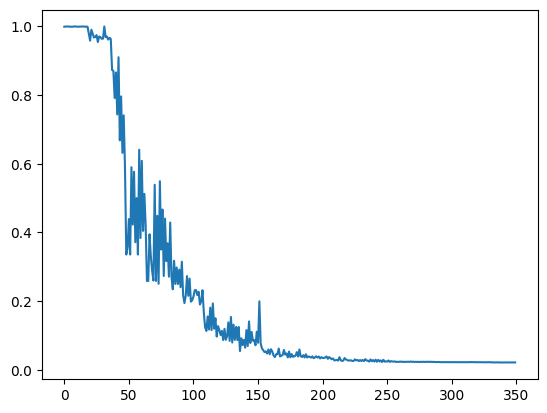

In [110]:
plt.plot(all_losses[(0.2, 2)][2])

In [111]:
X = np.array(all_losses[(0.2, 2)][2])

In [112]:
len(X)

350

In [113]:
loss_tol=0.85
delta_tol = 0.007
delta_window=5

In [114]:
for Y in delta_tol_conds:
    print(Y.shape)

(345,)
(345,)
(345,)
(345,)
(345,)


In [115]:
loss_tol_cond = X < loss_tol

dX_cond = np.abs((X[1:] - X[:-1])) < delta_tol
delta_tol_conds = [
    dX_cond[i:-delta_window+1+i] for i in range(delta_window-1)
]
delta_tol_conds.append(dX_cond[delta_window-1:])
delta_tol_conds = np.array(delta_tol_conds)

delta_tol_cond = np.all(delta_tol_conds, axis=0)

all_conds = loss_tol_cond[delta_window:] & delta_tol_cond

first_arg = np.argmax(all_conds) + delta_window + 1

In [116]:
len(dX_cond)

349

In [117]:
delta_tol_conds.shape

(5, 345)

In [118]:
X[first_arg-1]

0.033630549907684326

In [119]:
X[first_arg]

0.035792410373687744

In [120]:
first_arg

194

In [121]:
X[first_arg+1]

0.03919011354446411

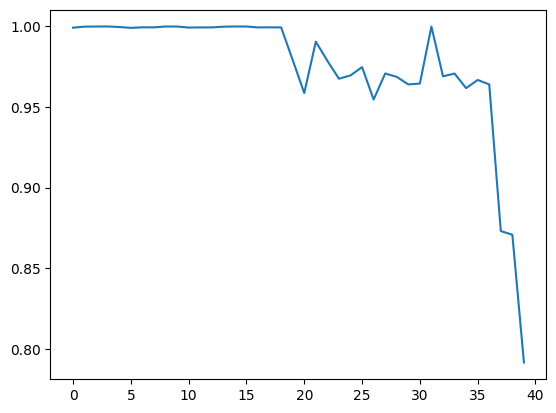

In [122]:
plt.plot(all_losses[(0.2, 2)][2][:40])

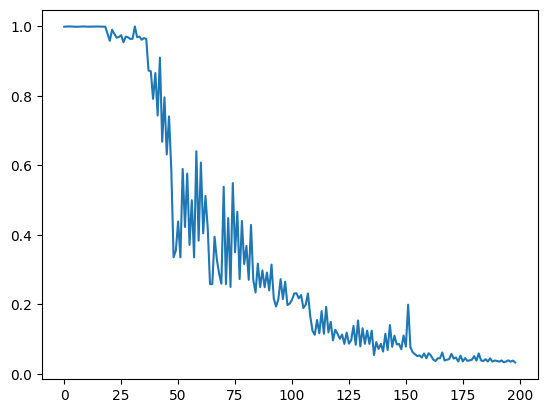

In [123]:
plt.plot(trunc_all_losses[(0.2, 2)][2])

In [124]:
grouped_num_iters_array = np.zeros((21, 3,  num_random_seeds))

for k1, b in enumerate(psi_dict):
    for k2 in range(3):
        for k3, X in enumerate(trunc_all_losses[(b, k2+1)]):
            grouped_num_iters_array[k1, k2, k3] = len(X)

In [125]:
mean_grouped_num_iters = np.mean(grouped_num_iters_array, axis=-1)
std_grouped_num_iters = np.std(grouped_num_iters_array, axis=-1)
min_grouped_num_iters = np.min(grouped_num_iters_array, axis=-1)
max_grouped_num_iters = np.max(grouped_num_iters_array, axis=-1)
first_quartile_grouped_num_iters = np.quantile(grouped_num_iters_array, 0.25, axis=-1)
third_quartile_grouped_num_iters = np.quantile(grouped_num_iters_array, 0.75, axis=-1)

# Final plots

In [84]:
b_params = list(psi_dict.keys())

In [85]:
b_params.remove(1)

In [86]:
b_params = np.array(b_params)

In [82]:
colors = [
    'tab:blue',
    'tab:orange',
    'tab:green'
]

symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

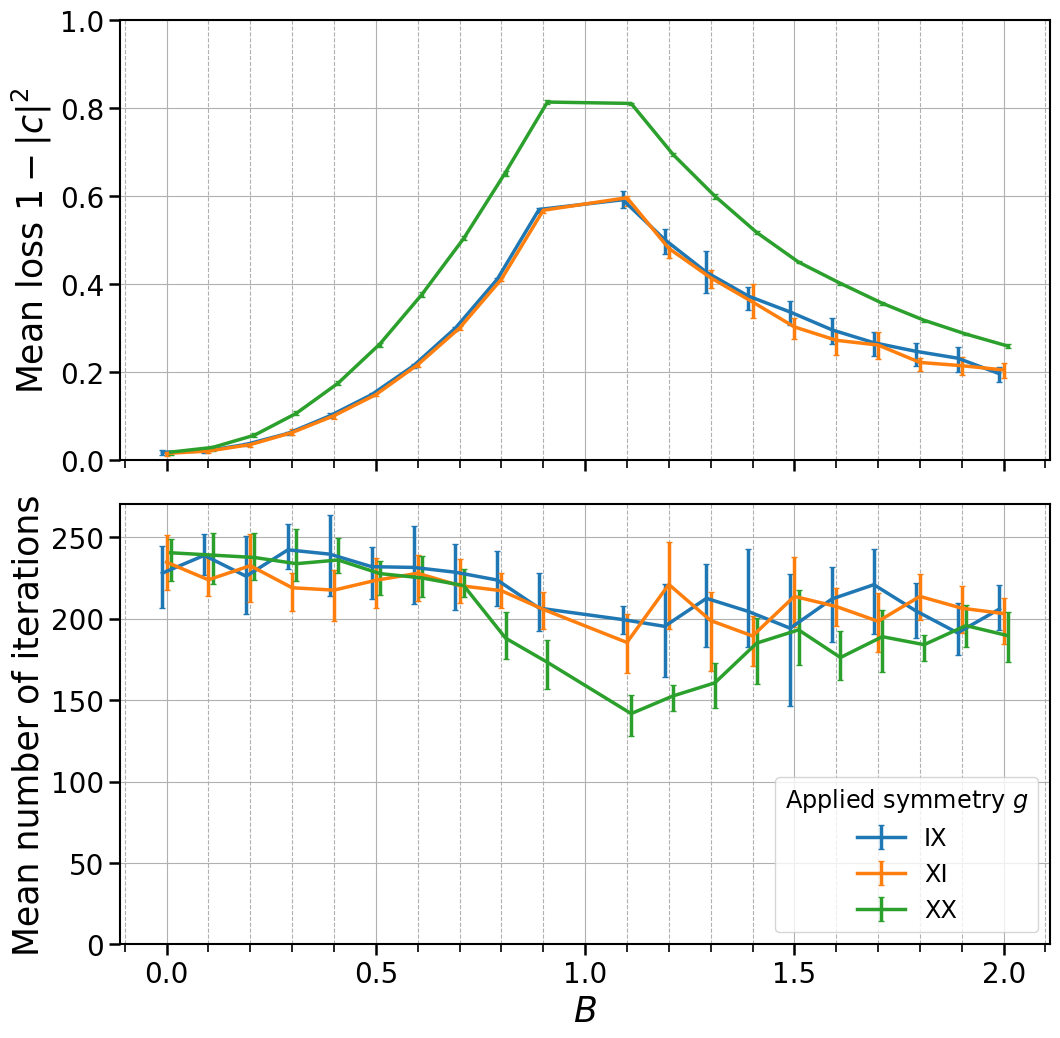

In [127]:
figure_label_fontsize=25
y_tick_label_fontsize=20
y_label_fontsize=25
x_tick_label_fontsize=20
x_label_fontsize=25
row_label_fontsize=25

axis_spine_linewidth = 1.5

major_tick_length = 8
major_tick_width = 1.8
minor_tick_length = 6
minor_tick_width = 1.2

phase_linewidth = 2.5

fig, ax_grid = plt.subplots(figsize=(12, 12), nrows=2)

for i, (col, label) in enumerate(zip(colors, symmetry_labels[1:])):
    x_shift = 0.01*(i-1)

    ax_grid[0].errorbar(
        b_params + x_shift,
            np.delete(mean_grouped_final_losses[:, i], 10, axis=0),
        yerr=[
            np.clip(np.delete(mean_grouped_final_losses - first_quartile_grouped_final_losses, 10, axis=0)[:,  i], a_min=0, a_max=np.inf),
            np.clip(np.delete(third_quartile_grouped_final_losses - mean_grouped_final_losses, 10, axis=0)[:, i], a_min=0, a_max=np.inf)
        ],
        fmt='-',
        capsize=2,
        linewidth=phase_linewidth,
        color=col,
        label=label
    )
    
    ax_grid[1].errorbar(
        b_params + x_shift,
        np.delete(mean_grouped_num_iters[:, i], 10, axis=0),
        yerr=[
            np.clip(np.delete(mean_grouped_num_iters - first_quartile_grouped_num_iters, 10, axis=0)[:, i], a_min=0, a_max=np.inf),
            np.clip(np.delete(third_quartile_grouped_num_iters - mean_grouped_num_iters, 10, axis=0)[:, i], a_min=0, a_max=np.inf)
        ],
        fmt='-',
        capsize=2,
        linewidth=phase_linewidth,
        color=col,
        label = label
    )

ax_grid[0].set_ylim(0, 1)
ax_grid[1].set_ylim(bottom=0)

for i, ax in enumerate(ax_grid):
    ax.xaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(0.5)
    )
    ax.xaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.1)
    )

    #ax.grid()
    ax.grid(
        which='major',
        axis='both',
        zorder=-1e10
    )
    
    ax.grid(
        which='minor',
        axis='both',
        linestyle='--',
        zorder=-1e10
    )
    
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(axis_spine_linewidth)

    ax.tick_params(
        axis='both',
        which='major',
        length=major_tick_length,
        width=major_tick_width
    )

    ax.tick_params(
        axis='both',
        which='minor',
        length=minor_tick_length,
        width=minor_tick_width
    )

    if i == 0:
        #ax.title.set_text(rf'Mean loss')
        #ax.title.set_fontsize(figure_label_fontsize)

        ax.set_xticklabels([])

    if i == 1:
        #ax.title.set_text(rf'Mean number of iterations')
        #ax.title.set_fontsize(figure_label_fontsize)

        ax.set_xlabel('$B$', fontsize=x_label_fontsize)

        ax.tick_params(
            axis='x',
            which='major',
            labelsize=x_tick_label_fontsize
        )

    ax.tick_params(
        axis='y',
        which='major',
        labelsize=y_tick_label_fontsize
    )

ax_grid[0].set_ylabel(
    r'Mean loss $1-\vert c \vert^2$',
    fontsize=y_label_fontsize
)
ax_grid[1].set_ylabel(
    r'Mean number of iterations',
    fontsize=y_label_fontsize
)

ax_grid[1].legend(
    loc='lower right',
    title='Applied symmetry $g$',
    fontsize='xx-large',
    title_fontsize='xx-large'
)

fig.subplots_adjust(wspace=0.05, hspace=0.1)

fig.savefig(
    r'plots/vqa_num_iterations.png',
    dpi=200,
    bbox_inches='tight'
)

# Conclusions
Converging in about 200 iterations.

# Old code

ValueError: 'yerr' must not contain negative values

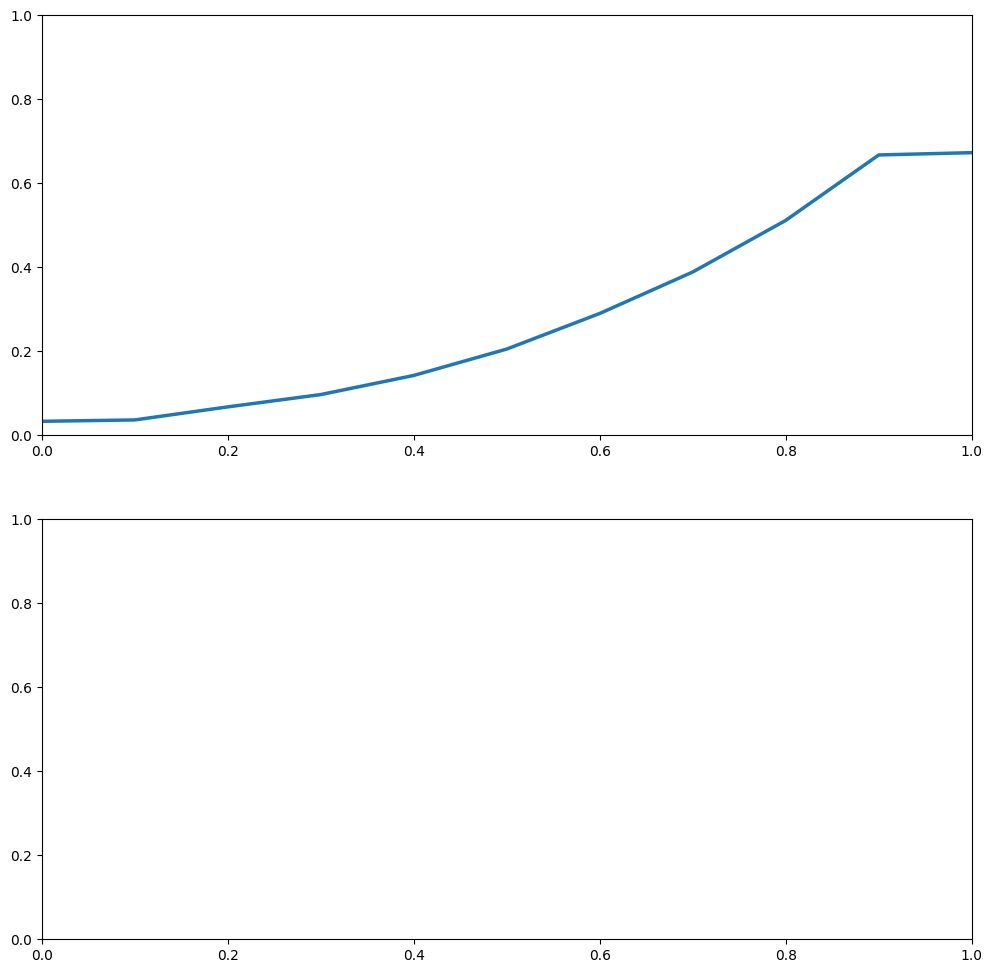

In [126]:
figure_label_fontsize=25
y_tick_label_fontsize=20
y_label_fontsize=25
x_tick_label_fontsize=20
x_label_fontsize=25
row_label_fontsize=25

axis_spine_linewidth = 1.5

major_tick_length = 8
major_tick_width = 1.8
minor_tick_length = 6
minor_tick_width = 1.2

phase_linewidth = 2.5

fig, ax_grid = plt.subplots(figsize=(12, 12), nrows=2)

ax_grid[0].errorbar(
    b_params,
        np.delete(mean_final_losses, 10),
    yerr=[
        np.delete(mean_final_losses - first_quartile_final_losses, 10),
        np.delete(third_quartile_final_losses - mean_final_losses, 10)
    ],
    color='tab:blue',
    fmt='-',
    capsize=2,
    linewidth=phase_linewidth
)

ax_grid[1].errorbar(
    b_params,
    np.delete(mean_num_iters, 10),
    yerr=[
        np.delete(np.array(mean_num_iters) - np.array(first_quartile_num_iters), 10),
        np.delete(np.array(third_quartile_num_iters) - np.array(mean_num_iters), 10)
    ],
    color='tab:blue',
    fmt='-',
    capsize=2,
    linewidth=phase_linewidth
)

ax_grid[0].set_ylim(0, 1)
ax_grid[1].set_ylim(bottom=0)

for i, ax in enumerate(ax_grid):
    ax.xaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(0.5)
    )
    ax.xaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.1)
    )

    #ax.grid()
    ax.grid(
        which='major',
        axis='both',
        zorder=-1e10
    )
    
    ax.grid(
        which='minor',
        axis='both',
        linestyle='--',
        zorder=-1e10
    )
    
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(axis_spine_linewidth)

    ax.tick_params(
        axis='both',
        which='major',
        length=major_tick_length,
        width=major_tick_width
    )

    ax.tick_params(
        axis='both',
        which='minor',
        length=minor_tick_length,
        width=minor_tick_width
    )

    if i == 0:
        #ax.title.set_text(rf'Mean loss')
        #ax.title.set_fontsize(figure_label_fontsize)

        ax.set_xticklabels([])

    if i == 1:
        #ax.title.set_text(rf'Mean number of iterations')
        #ax.title.set_fontsize(figure_label_fontsize)

        ax.set_xlabel('$B$', fontsize=x_label_fontsize)

        ax.tick_params(
            axis='x',
            which='major',
            labelsize=x_tick_label_fontsize
        )

    ax.tick_params(
        axis='y',
        which='major',
        labelsize=y_tick_label_fontsize
    )

ax_grid[0].set_ylabel(
    r'Mean loss $1-\vert c \vert^2$',
    fontsize=y_label_fontsize
)
ax_grid[1].set_ylabel(
    r'Mean number of iterations',
    fontsize=y_label_fontsize
)

fig.subplots_adjust(wspace=0.05, hspace=0.1)
"""
fig.savefig(
    r'plots/mpo_bosonic_results.png',
    dpi=200,
    bbox_inches='tight'
)
"""